<a href="https://colab.research.google.com/github/ThomasWong-ST/Intro-to-RL/blob/main/Temporal_Difference_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulations for TD Learning
Windy GridWorld

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

class WindyGridWorld:
    """
    Sutton & Barto, Example 6.5 (Windy Gridworld)
    - Grid: 7 rows x 10 cols (row 0 at top, row increases downward)
    - Start S=(3,0), Goal G=(3,7)  [0-indexed]
    - Reward: -1 per step until goal
    - Discount: γ=1.0 (episodic, undiscounted)
    - Wind: pushes UP by w[col] cells after the agent's intended move
      Standard wind strengths: [0,0,0,1,1,1,2,2,1,0]
    """
    def __init__(self, seed=0):
        self.n_rows, self.n_cols = 7, 10
        self.start = (3, 0)
        self.goal  = (3, 7)
        self.step_cost = -1.0
        #self.rng = np.random.default_rng(seed)

        # Standard deterministic wind per column (upward shift)
        self.wind = [0,0,0,1,1,1,2,2,1,0]

        self.state = None  # (row, col)

    def reset(self):
        """Reset to fixed start (as in the book). Return state index."""
        self.state = self.start
        return self._to_index(self.state)

    def step(self, action):
        """
        Apply action, then wind. Return: (next_state_idx, reward, done, info)
        """
        r, c = self.state

        # 1) agent’s intended move
        nr, nc = r, c
        if action == UP:    nr -= 1
        if action == DOWN:  nr += 1
        if action == LEFT:  nc -= 1
        if action == RIGHT: nc += 1
        nr = np.clip(nr, 0, self.n_rows - 1)#exp: a = np.clip(3, 0, 4-1), a=3, if np.clip(3, 0, 3-1) than a=2
        nc = np.clip(nc, 0, self.n_cols - 1)

        # 2) wind pushes UP by wind[nc] (applies after movement, uses destination column)
        nr = np.clip(nr - self.wind[nc], 0, self.n_rows - 1)

        self.state = (nr, nc)
        done = (self.state == self.goal)
        reward = 0.0 if done else self.step_cost
        return self._to_index(self.state), reward, done, {}

    # --- helpers (same style as your class) ---
    def _to_index(self, rc):
        r, c = rc
        return r * self.n_cols + c

    def _from_index(self, idx):
        return divmod(idx, self.n_cols)

    @property
    def nS(self):  # number of states
        return self.n_rows * self.n_cols

    @property
    def nA(self):  # number of actions
        return len(ACTIONS)




In [ ]:
Q = np.zeros((7, 10), dtype=float)
print(np.random.randint(Q.shape[1]))
print(Q[0])

9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
def make_epsilon_greedy(epsilon=0.1, tie_break="random"):
    """
    Returns a policy function: policy(Q, s) -> action.
    - epsilon: exploration rate
    - tie_break: 'random' (uniform among argmax) or 'first' (np.argmax)
    """
    def policy(Q, s):
        # choose random action with probability epsilon
        if np.random.rand() < epsilon:  # correct random scalar
            return int(np.random.randint(Q.shape[1]))  # random action

        q = Q[s]
        if tie_break == "random":
            best = np.flatnonzero(q == q.max())
            return int(np.random.choice(best))
        else:
            return int(np.argmax(q))

    return policy
    """
    what happens is that I initially have my Q table
    Q = np.zeros((env.nS, env.nA), dtype=float), than when
    I have Q[s], and s = env.reset(), it starts at
    the position (3, 0), and Q[s] returns a list with
    four elements, each element denotes the action value
    corresponding to the actions [0,1,2,3], I choose the maximum
    value with an epsilon chance of randomly choosing a action;
    than the function policy returns the next action being chosen.
    """

In [ ]:
env = WindyGridWorld()
Q = np.zeros((env.nS, env.nA), dtype=float)
alpha = make_epsilon_greedy(epsilon=0.1)
#print(Q)
print(Q[env.reset()])
print(alpha(Q, 0))
print(env.reset())
print(alpha(Q, env.reset()))
del(alpha)

[0. 0. 0. 0.]
0
30
0


In [ ]:
def plot_path(env, states, title="Path followed by agent"):
    """
    Plot the sequence of states visited on the WindyGridWorld grid.
    """
    if not states:
        print("No states to plot.")
        return

    # convert 1D indices to (row, col)
    rc = [env._from_index(s) for s in states]
    rs = np.array([r for r, c in rc])
    cs = np.array([c for r, c in rc])

    rows, cols = env.n_rows, env.n_cols

    fig, ax = plt.subplots(figsize=(8, 5))
    # draw grid lines
    for r in range(rows + 1):
        ax.plot([-0.5, cols - 0.5], [r - 0.5, r - 0.5], color="gray", linewidth=0.5)
    for c in range(cols + 1):
        ax.plot([c - 0.5, c - 0.5], [-0.5, rows - 0.5], color="gray", linewidth=0.5)

    # draw path (note: row 0 = top)
    ax.plot(cs, rs, color="blue", linewidth=2, marker="o", markersize=4, label="Path")

    # start & goal
    sr, sc = env.start
    gr, gc = env.goal
    ax.scatter(sc, sr, s=120, c="green", marker="s", label="Start", zorder=3)
    ax.scatter(gc, gr, s=120, c="red", marker="*", label="Goal", zorder=3)

    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)  # invert y-axis
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.legend()
    plt.show()

In [ ]:
def generate_episode(env, Q, epsilon=0.0, max_steps=1000):
    """
    generate_episode just reproduces the sets of actions that follows the largest Q-value
    from the Q-table created by either SARSA or Q-learning. We can set epsilon = 0,
    (unless we want to explore differnt Q-values) and return a list of
    states, actions and rewards for the Q-table used.

    Generate one episode using the learned Q-table.
    If epsilon > 0, follow an epsilon-greedy policy (exploration).
    If epsilon = 0, follow a greedy policy (pure exploitation).
    """
    states, actions, rewards = [], [], []
    state = env.reset()

    for _ in range(max_steps):
        # --- ε-greedy action from Q ---
        if np.random.rand() < epsilon:
            action = np.random.randint(env.nA)
        else:
            q = Q[state]
            best = np.flatnonzero(q == q.max())
            action = int(np.random.choice(best))

        next_state, reward, done, _ = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        state = next_state

        if done:
            break

    return states, actions, rewards

SARSA: On-policy TD Control

In [ ]:
def SARSA(
    env,
    policy,                 # callable: policy(Q, s) -> a
    episodes=200,
    gamma=1.0,
    alpha=0.5,
    max_steps=10_000,
    track_returns=True
):
    #rng = np.random.default_rng(seed)

    # init Q
    Q = np.zeros((env.nS, env.nA), dtype=float)

    ep_lengths = [] #stores the length of the episodes
    ep_returns = [] if track_returns else None #stores the returns of the episodes

    for ep in range(episodes):
        s = env.reset()
        a = policy(Q, s)

        G = 0.0
        steps = 0

        while steps < max_steps:
            s_next, r, done, _ = env.step(a)

            """
            s_next, r, done, _:
            - s_next could take on an value between 0 and 69 denoting the states
            - r would return either -1 or 0 when we reach terminal (depending on the s_next)
            - done is a booelean value, returning if done = true or done = false
            -  _ the underscore indicate that a variable's value is not going to be used
            """
            G += r

            if done:#if done = true than use the terminal SARSA equation, V(S_t+1 = terminal) = 0
                # terminal target: just r (no bootstrap)
                td_target = r
                Q[s, a] += alpha * (td_target - Q[s, a])
                steps += 1
                break

            # on-policy action for next state
            a_next = policy(Q, s_next)

            # SARSA target and update
            td_target = r + gamma * Q[s_next, a_next]
            Q[s, a] = Q[s, a] + alpha * (td_target - Q[s, a])

            s, a = s_next, a_next
            steps += 1

        ep_lengths.append(steps)
        if track_returns:
            ep_returns.append(G)

    info = {
        "episode_lengths": np.array(ep_lengths),
        "episode_returns": np.array(ep_returns) if track_returns else None
    }
    return Q#, info

In [ ]:
env = WindyGridWorld()
Q = SARSA(env, make_epsilon_greedy(epsilon=0.1),episodes=1000, track_returns = False)
generate_episode(env, Q, epsilon = 0.1)[0]

[30,
 np.int64(31),
 np.int64(41),
 np.int64(42),
 np.int64(33),
 np.int64(24),
 np.int64(24),
 np.int64(15),
 np.int64(6),
 np.int64(7),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(7),
 np.int64(8),
 np.int64(8),
 np.int64(9),
 np.int64(19),
 np.int64(29),
 np.int64(39),
 np.int64(49),
 np.int64(59),
 np.int64(69),
 np.int64(58)]

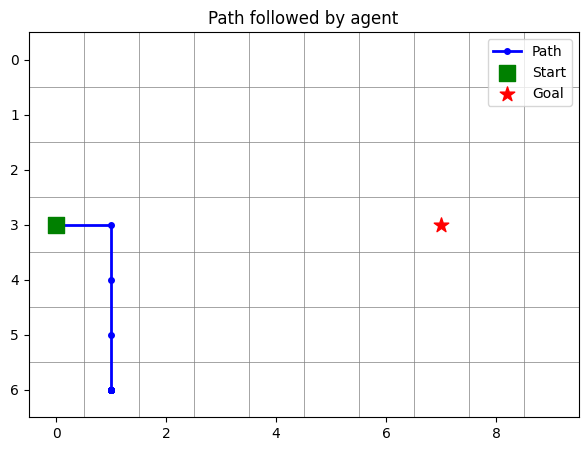

In [ ]:
plot_path(env, generate_episode(env, Q = SARSA(env, make_epsilon_greedy(epsilon=0.1),episodes=100, track_returns = False), epsilon = 0)[0])

Q-learning: Off-policy TD control

In [ ]:
def Q_learning(
    env,
    policy,                 # callable: policy(Q, s) -> a
    episodes=200,
    gamma=1.0,
    alpha=0.5,
    max_steps=10_000,
    track_returns=True
):
    #rng = np.random.default_rng(seed)

    # init Q
    Q = np.zeros((env.nS, env.nA), dtype=float)

    ep_lengths = [] #stores the length of the episodes
    ep_returns = [] if track_returns else None #stores the returns of the episodes

    for ep in range(episodes):
        s = env.reset()
        a = policy(Q, s)

        G = 0.0
        steps = 0

        while steps < max_steps:
            s_next, r, done, _ = env.step(a)

            G += r

            if done:
                # terminal target: just r (no bootstrap)
                td_target = r
                Q[s, a] = Q[s, a] + alpha * (td_target - Q[s, a])
                steps += 1
                break

            # on-policy action for next state
            a_next = policy(Q, s_next)

            # Q-learning target and update
            max_action = np.max(Q[s_next])
            td_target = r + gamma * max_action
            Q[s, a] = Q[s, a] + alpha * (td_target - Q[s, a])

            s, a = s_next, a_next
            steps += 1

        ep_lengths.append(steps)
        if track_returns:
            ep_returns.append(G)

    info = {
        "episode_lengths": np.array(ep_lengths),
        "episode_returns": np.array(ep_returns) if track_returns else None
    }
    return Q#, info

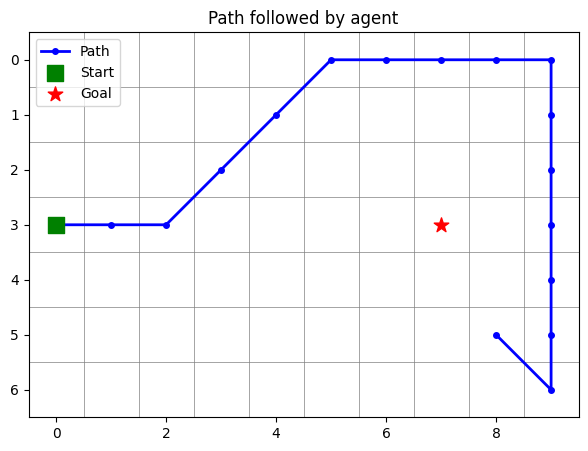

In [ ]:
env = WindyGridWorld()
plot_path(env, generate_episode(env, Q = Q_learning(env, make_epsilon_greedy(epsilon=0.1),episodes=1000, track_returns = False), epsilon = 0)[0])